In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import time
import scipy as sp
import ot
import sys

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import time
import scienceplots

import jpype
import jpype.imports
from jpype.types import *
jpype.startJVM("-Xmx10000m", classpath=['../baselines/optimaltransport.jar'])
from optimaltransport import Mapping


sys.path.append('../')
from baselines import solvers_L2_UOT as sl2
from sliced import all_sliced_pw
from kneed import KneeLocator

%matplotlib inline


This code has been adapted from the figure 4 of 
```
@article{chapel2021unbalanced,
  title={Unbalanced optimal transport through non-negative penalized linear regression},
  author={Chapel, Laetitia and Flamary, R{\'e}mi and Wu, Haoran and F{\'e}votte, C{\'e}dric and Gasso, Gilles},
  journal={Advances in Neural Information Processing Systems},
  volume={34},
  pages={23270--23282},
  year={2021}
}```


### Load datasets and compose the training and test sets

#### Load MNIST dataset

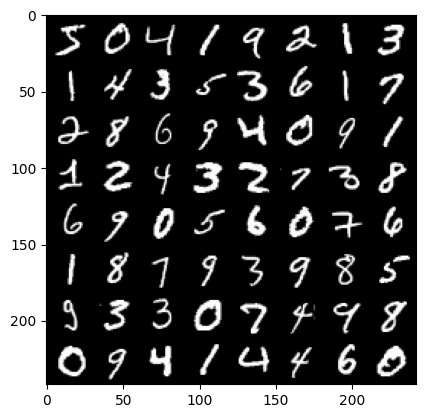

In [2]:
#put download=True in the following instructions to download the dataset 
transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST(root="./data/",train=True,transform=transform, download=False)
data_test = datasets.MNIST(root="./data/",train=False,transform=transform, download=False)
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=False)
data_loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=64, shuffle=False)
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
plt.imshow(img)
plt.show()

#### Load fashin MNIST dataset

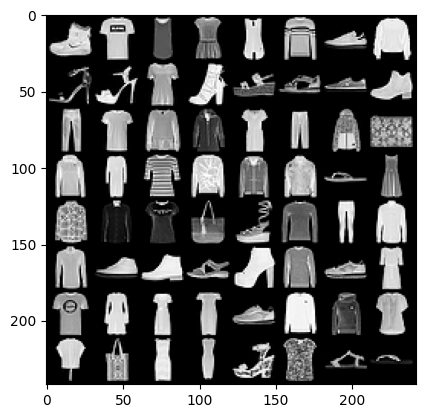

In [3]:
#put download=True in the following instructions to download the dataset 
fashion_train = torchvision.datasets.FashionMNIST("./data", download=False, transform=
                                                transforms.Compose([transforms.ToTensor()]))
fashion_test = torchvision.datasets.FashionMNIST("./data", download=False, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
data_loader_train = torch.utils.data.DataLoader(dataset=fashion_train, batch_size=64, shuffle=False)
data_loader_test = torch.utils.data.DataLoader(dataset=fashion_test, batch_size=64, shuffle=False)

images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
plt.imshow(img)
plt.show()

In [4]:
fashion_train = (fashion_train.train_data, fashion_train.train_labels)
fashion_test = (fashion_test.train_data, fashion_test.train_labels)
images_fashion_train = fashion_train[0].numpy()
labels_fashion_train = fashion_train[1].numpy()
images_fashion_test = fashion_test[0].numpy()
labels_fashion_test = fashion_test[1].numpy()

mnist_train = (data_train.train_data, data_train.train_labels)
mnist_test = (data_test.train_data, data_test.train_labels)
images_train = mnist_train[0].numpy()
labels_train = mnist_train[1].numpy()
images_test = mnist_test[0].numpy()
labels_test = mnist_test[1].numpy()

### Useful functions

In [5]:
def make_subsets(images, labels, list_of_labels, nb_points_per_class):
    if type(nb_points_per_class) == int:
        nb_points_per_class = [nb_points_per_class] * len(list_of_labels)
    perm = []
    for l in range(len(list_of_labels)):
        idx = np.where(labels == list_of_labels[l])[0]
        idx_sel = np.random.permutation(len(idx))[:nb_points_per_class[l]]
        perm = perm + idx[idx_sel].tolist()
    return images[perm].reshape(-1, 28 * 28), labels[perm]

def compute_error(G, source_label, target_label, thres=0.5):
    pt_assigned = 0
    pt_correct = 0
    for j in range(np.shape(G)[1]):
        i = np.argmax(G[:,j])
        if np.sum(G[:,j]) > thres / G.shape[1]: 
            pt_assigned += 1
            if source_label[i] == target_label[j]:
                pt_correct += 1
    return pt_assigned, pt_correct

def compute_error_spw(subset_y, mass_in_common):
    pt_correct = np.sum(subset_y<=mass_in_common)
    return pt_correct

def compute_error_potp(subset_y, mass_in_common):
    pt_correct = np.sum(subset_y<=mass_in_common)
    return pt_correct

#useful functions for OT profiles
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def GTOT(X=None, Y=None, lambda_val=None, delta=0.1, S=1):
    dist = sp.spatial.distance.cdist(X, Y, metric='minkowski', p=1)
    nz = len(X)
    supplies = list(map(float, [1.0] * nz))
    demands = list(map(float, [1.0] * nz))
    gtSolver = Mapping(nz, supplies, demands, dist, delta)
    def_l = np.array(gtSolver.getDefLog()).T
    return def_l

### UOT experiment: only half of the classes are in common in the training and test set

In [6]:
nb_samples = 200

list_labels_source_mnist = [0, 1, 2, 3]
list_labels_target_mnist = [0, 1]
list_labels_target_fashion = [8, 9]
mass_in_common = len(list(set(list_labels_source_mnist) & set(list_labels_target_mnist + list_labels_target_fashion))) * nb_samples

def draw_random_samples():
    train_mnist_x, train_mnist_l = make_subsets(images_train, labels_train, list_labels_source_mnist, nb_samples)
    test_mnist_x, test_mnist_l = make_subsets(images_train, labels_train, list_labels_target_mnist, nb_samples)
    test_fashion_x, test_fashion_l = make_subsets(images_fashion_train, labels_fashion_train, list_labels_target_fashion, nb_samples)

    train_x = train_mnist_x
    test_x = np.concatenate((test_mnist_x, test_fashion_x))
    list_labels_source = train_mnist_l
    list_labels_target = np.concatenate((test_mnist_l, test_fashion_l))
    return train_x, test_x, list_labels_source, list_labels_target



### Compute UOT with L2 reg and the regularization path but also UOT with PAWL and monitor the timings

In [7]:
nb_reps = 10
timings_UOT_L2 = np.zeros(nb_reps)
timings_UOT_PAWL = np.zeros(nb_reps)
timing_POTP = np.zeros(nb_reps)

res_overall_all = []
pt_assigned_all = []

res_overall_all_spw = []
res_overall_all_potp = []

for j in range(nb_reps):
    print("iter",j)

    train_x, test_x, list_labels_source, list_labels_target = draw_random_samples()
    a = ot.unif(nb_samples * len(list_labels_source_mnist))
    b = ot.unif(nb_samples * len(list_labels_source_mnist))

    start_UOT_L2 = time.time()
    C = sp.spatial.distance.cdist(train_x, test_x)
    C = C / C.max()
    _, _, T_list, _, _ = sl2.ot_ul2_reg_path(a, b, C, savePi=True)
    timings_UOT_L2[j] = time.time() - start_UOT_L2

    for T in T_list:
        pt_assigned, pt_correct = compute_error(T.toarray(), list_labels_source, list_labels_target, thres=0.25)
        res_overall_all.append(pt_correct)
        pt_assigned_all.append(pt_assigned)

    start_POTP = time.time()
    train_x_float = train_x.astype(float)/255.
    test_x_float = test_x.astype(float)/255.
    T_potp = GTOT(X=test_x_float, Y=train_x_float, lambda_val=None, delta=1e-3, S=1)
    timing_POTP[j] = time.time() - start_POTP
    def_b = np.sum((T_potp[:len(test_x_float), :]>0.1).astype(int), axis=0)
    for i in range(0,len(test_x_float)):
        def_ind = np.where(def_b == i)
        if len(def_ind[0])==0: #no solution, just in case
            res_overall_all_potp.append(np.nan)
        else:
            lab = T_potp[0:len(test_x_float), def_ind[-1][-1]]
            val = np.sum(lab[nb_samples*2:]>0.1)
            res_overall_all_potp.append(nb_samples*2 - np.sum(lab[nb_samples*2:])) #because estimates the other class


    start_UOT_PAWL = time.time()
    subset_x, subset_y, cum_costs = all_sliced_pw(train_x, test_x, None, train_x.shape[0])
    timings_UOT_PAWL[j] = time.time() - start_UOT_PAWL
    min_cum_costs = np.min(cum_costs, 0)
    line_min_cum_costs = np.argmin(cum_costs, 0)
    for i in range(min_cum_costs.shape[0]):
        optimal_line = line_min_cum_costs[i]
        optimal_subset_y = subset_y[optimal_line]
        pt_correct = compute_error_spw(optimal_subset_y[:i], mass_in_common)
        res_overall_all_spw.append(pt_correct)

    

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9


### Timings

In [10]:
print("--------timings, in secs--------")
print("for UOT l2", np.round(np.mean(timings_UOT_L2),2))
print("for pawl", np.round(np.mean(timings_UOT_PAWL),2))
print("for POTP", np.round(np.mean(timing_POTP),2))

--------timings, in secs--------
for UOT l2 191.21
for pawl 0.96
for POTP 12.22


### formatting the results to plot them


In [11]:
#UOT L2
mean_acc_uot_l2 = np.zeros(test_x.shape[0]+1)
min_acc_uot_l2 = np.ones(test_x.shape[0]+1)*np.inf
max_acc_uot_l2 = np.zeros(test_x.shape[0]+1)
len_uot_l2 = np.zeros(test_x.shape[0]+1)

for i in range(1,len(pt_assigned_all)):
    if pt_assigned_all[i-1] != pt_assigned_all[i]:
        mean_acc_uot_l2[pt_assigned_all[i]] =  mean_acc_uot_l2[pt_assigned_all[i]]+res_overall_all[i]
        len_uot_l2[pt_assigned_all[i]] = len_uot_l2[pt_assigned_all[i]] +1
        if min_acc_uot_l2[pt_assigned_all[i]] > res_overall_all[i]:
            min_acc_uot_l2[pt_assigned_all[i]] = res_overall_all[i]
        elif max_acc_uot_l2[pt_assigned_all[i]] < res_overall_all[i]:
            max_acc_uot_l2[pt_assigned_all[i]] = res_overall_all[i]

mean_acc_uot_l2 = mean_acc_uot_l2[1:]/len_uot_l2[1:]
min_acc_uot_l2 = min_acc_uot_l2[1:]
max_acc_uot_l2 = max_acc_uot_l2[1:]

#PAWL
res_overall_all_spw = np.array(res_overall_all_spw).reshape(nb_reps, min_cum_costs.shape[0])
mean_res_overall_all_spw = np.mean(res_overall_all_spw, axis=0)
min_res_overall_all_spw = np.min(res_overall_all_spw, axis=0)
max_res_overall_all_spw = np.max(res_overall_all_spw, axis=0)

#POTP
res_overall_all_potp = np.array(res_overall_all_potp).reshape(nb_reps, int(test_x.shape[0]))
mean_res_overall_all_potp = np.nanmean(res_overall_all_potp, axis=0)
min_res_overall_all_potp = np.nanmin(res_overall_all_potp, axis=0)
max_res_overall_all_potp = np.nanmax(res_overall_all_potp, axis=0)

### Draw figure 7

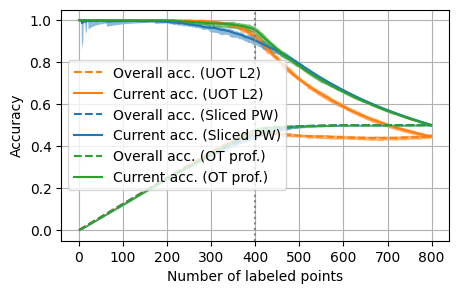

In [12]:
##plt.rcParams['text.usetex'] = True
#plt.style.use(['science'])
#plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(5, 3))
plt.plot(np.arange(0,test_x.shape[0]), mean_acc_uot_l2/len(test_x), "--", color="C1", label="Overall acc. (UOT L2)")
plt.fill_between(np.arange(0,test_x.shape[0]), min_acc_uot_l2/len(test_x), max_acc_uot_l2/len(test_x),  color="C1", alpha=0.5)
plt.plot(np.arange(0,test_x.shape[0]), mean_acc_uot_l2/np.arange(1,test_x.shape[0]+1), color="C1", label="Current acc. (UOT L2)")
plt.fill_between(np.arange(0,test_x.shape[0]), min_acc_uot_l2/np.arange(1,test_x.shape[0]+1), max_acc_uot_l2/np.arange(1,test_x.shape[0]+1), color="C1", alpha=0.5)
plt.plot(np.arange(0,test_x.shape[0]), mean_res_overall_all_spw/len(test_x), '--', color="C0", label="Overall acc. (Sliced PW)")
plt.fill_between(np.arange(0,test_x.shape[0]), min_res_overall_all_spw/len(test_x), max_res_overall_all_spw/len(test_x),  color="C0", alpha=0.5)
plt.plot(np.arange(0,test_x.shape[0]),mean_res_overall_all_spw/np.arange(0,test_x.shape[0]),  color="C0",label="Current acc. (Sliced PW)")
plt.fill_between(np.arange(0,test_x.shape[0]), min_res_overall_all_spw/np.arange(0,test_x.shape[0]), max_res_overall_all_spw/np.arange(0,test_x.shape[0]), alpha=0.5)

plt.plot(np.arange(0,test_x.shape[0]), 0.5-mean_res_overall_all_potp/len(test_x), '--', color="C2", label="Overall acc. (OT prof.)")
plt.fill_between(np.arange(0,test_x.shape[0]), 0.5-min_res_overall_all_potp/len(test_x), 0.5-max_res_overall_all_potp/len(test_x),  color="C2", alpha=0.5)
plt.plot(np.arange(0,test_x.shape[0]),1-mean_res_overall_all_potp[::-1]/np.arange(0,test_x.shape[0]),  color="C2",label="Current acc. (OT prof.)")
plt.fill_between(np.arange(0,test_x.shape[0]), 1-min_res_overall_all_potp[::-1]/np.arange(0,test_x.shape[0]), 1-max_res_overall_all_potp[::-1]/np.arange(0,test_x.shape[0]), color="C2", alpha=0.5)


plt.ylabel("Accuracy")
plt.xlabel("Number of labeled points")
plt.axvline(x=mass_in_common, color='Grey', linestyle='dotted')
plt.legend()
plt.grid()
plt.savefig('Expe_SPW_classification.pdf', bbox_inches='tight', pad_inches=0) 
plt.show()

In [12]:
np.savez("figure7", test_x, mean_acc_uot_l2, min_acc_uot_l2, max_acc_uot_l2, mean_res_overall_all_spw,
         min_res_overall_all_spw, max_res_overall_all_spw, mean_res_overall_all_potp, min_res_overall_all_potp,
         max_res_overall_all_potp)
